In [1]:
import pandas as pd
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import anndata as an
import scanpy as sc
import scipy
from transformers import BertConfig, BertForMaskedLM, AdamW, DataCollatorForLanguageModeling
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, TensorDataset

source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import matrix as matrix
import centrality as central

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get input

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/population_pore_c/chr1_1000000_incidence.parquet"

df = pd.read_parquet(fpath)
print(f"{df.shape=}")
df.head()

df.shape=(193, 122676)


read_code,65057,21695,119867,7453,65998,81009,110088,18720,89300,115287,...,47296,6202,3069,97901,6136,88389,111230,69764,94327,2373
bin,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Convert into "tokens"

In [3]:
max_length = 10
bin_names = df.T.columns.astype(int).to_numpy()

def format_input(token_list, max_length=12, pad_token=0):
    """A function to format a token list"""
    
    # truncate long
    if len(token_list) > max_length:
        token_list = token_list[:max_length]
    # pad short
    else:
        short = max_length - len(token_list)
        token_list = list(token_list) + ([pad_token] * short)
    return list(token_list)
    

tokens = df.T.apply(lambda x: bin_names[np.argwhere(x != 0).ravel()], axis=1)
tokens = tokens.reset_index()
tokens.columns = ['read_code', 'raw_input']
tokens['order'] = tokens['raw_input'].apply(lambda x: len(x))
tokens['input_ids'] = tokens['raw_input'].apply(lambda x: format_input(x, max_length=max_length))
tokens['length'] = tokens['input_ids'].apply(lambda x: len(x))
tokens.head()

,read_code,raw_input,order,input_ids,length
0,65057,"[31, 41, 42, 43, 62, 63, 64, 82]",8,"[31, 41, 42, 43, 62, 63, 64, 82, 0, 0]",10
1,21695,"[71, 73, 127, 180]",4,"[71, 73, 127, 180, 0, 0, 0, 0, 0, 0]",10
2,119867,"[8, 183]",2,"[8, 183, 0, 0, 0, 0, 0, 0, 0, 0]",10
3,7453,"[100, 111, 119]",3,"[100, 111, 119, 0, 0, 0, 0, 0, 0, 0]",10
4,65998,"[145, 169]",2,"[145, 169, 0, 0, 0, 0, 0, 0, 0, 0]",10


In [4]:
# Example integer data (already tokenized)
input_ids = torch.tensor(tokens['input_ids'].to_list())
print(f"{input_ids.shape=}")

# Create dataset and dataloader
dataset = TensorDataset(input_ids)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True) 
print('done!')

input_ids.shape=torch.Size([122676, 10])
done!


# Train a model

In [5]:
vocab_size = 200
mask_token_id = 199
unk_token_id = 198
masking_prob = 0.15
learning_rate = 1e-4
num_hidden_layers = 2
num_attention_heads = 2
output_shape = 10
num_epochs = 3

print(f"{vocab_size=}")

# Model Configuration
config = BertConfig(
    vocab_size=vocab_size, 
    hidden_size=output_shape,
    num_hidden_layers=num_hidden_layers,
    output_hidden_states=True,
    num_attention_heads=num_attention_heads,
    intermediate_size=output_shape * 2,
    max_position_embeddings=max_length,
)

model = BertForMaskedLM(config)

# Masking
def apply_masking(batch, mask_token_id=mask_token_id, mlm_probability=masking_prob):
    labels = batch.clone()  
    probability_matrix = torch.full(labels.shape, mlm_probability)
    
    # Create a mask for positions to be masked
    special_tokens_mask = [
        [i == 0 or i == len(b) - 1 for i in range(len(b))] for b in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  

    # Replace masked indices with mask token id
    batch[masked_indices] = mask_token_id
    return batch, labels


# Training Loop
optimizer = AdamW(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model.to(device)

for epoch in range(num_epochs):
    total_loss = 0.0  # Track total loss for the epoch

    for batch in data_loader:
        optimizer.zero_grad()
        
        # Apply masking using our custom function
        batch = batch[0].to(device) 
        
        # Handle OOV tokens (replace with UNK token)
        batch[batch >= vocab_size - 1] = unk_token_id
        batch, labels = apply_masking(batch)  

        # Forward pass
        outputs = model(batch, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()  # Accumulate loss

        # Backward pass
        loss.backward()
        optimizer.step()
    
    # Print average loss after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {total_loss:.2f}")

vocab_size=200


/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/3, Total Loss: 22935.50
Epoch 2/3, Total Loss: 17210.16
Epoch 3/3, Total Loss: 17038.35


# Extract learned embeddings

In [6]:
sample_size = 10000
sample = tokens.sample(sample_size)

new_input = torch.tensor(sample['input_ids'].to_list())
print(f"{new_input.shape=}")

# Move to the same device as the model
new_input = new_input.to(device)

# Get the model's prediction (logits for each masked position)
with torch.no_grad():  # No need to track gradients for this
    outputs = model(new_input)
    
embeddings = outputs.hidden_states[-1] 
embeddings.shape

new_input.shape=torch.Size([10000, 10])


torch.Size([10000, 10, 10])

# Loci embeddings

In [7]:
result = []

for i, (_, row) in enumerate(sample.iterrows()):
    n = min(row['order'], max_length)
    bins = row['raw_input'][:n] # handle raw inputs larger than the max length

    mat = embeddings[i, 0:n, :].cpu().detach().numpy()
    mat = pd.DataFrame(mat, index=bins)
    result.append(mat)

result = pd.concat(result)
result = result.reset_index(names='loci')

# average ovber the loci embeddings
result = result.groupby('loci').mean()

result.head()

,0,1,2,3,4,5,6,7,8,9
loci,,,,,,,,,,
4,0.910960,0.175134,1.361021,-0.690070,-0.663084,-0.890744,1.485897,-0.248224,-0.493286,-0.569321
5,0.556485,0.317196,0.880178,-0.990784,-0.698005,-0.715706,1.670575,-0.046757,-0.487710,-0.143073
6,0.613502,0.354704,0.802521,-0.802365,-0.752787,-0.727002,1.639203,-0.069841,-0.493499,-0.218256
7,0.613146,0.256133,0.946604,-0.857622,-0.708208,-0.752461,1.581660,0.020337,-0.520657,-0.226020
8,0.456943,0.301295,0.677161,-1.145234,-0.715104,-0.635312,1.618843,0.055172,-0.406741,0.104924


/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_3684644/4070959021.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


AnnData object with n_obs × n_vars = 193 × 10
    obs: 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

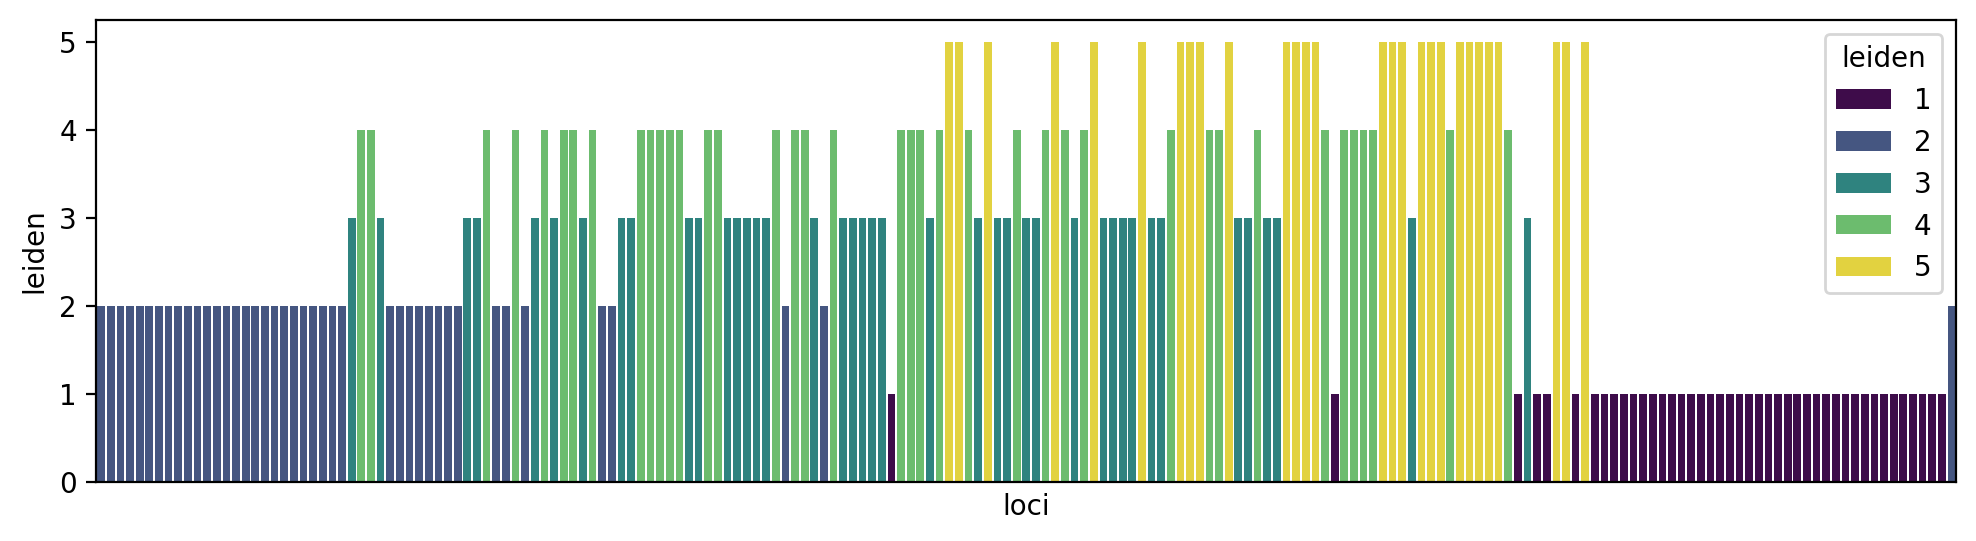

In [8]:
# Create AnnData object
adata = an.AnnData(
    X=result,
)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 3

sns.barplot(x=adata.obs_names.astype(int),
            y=adata.obs['leiden'].astype(int) + 1,
            hue=adata.obs['leiden'].astype(int) + 1,
            palette='viridis',
            )

plt.xticks([])
adata

<Axes: >

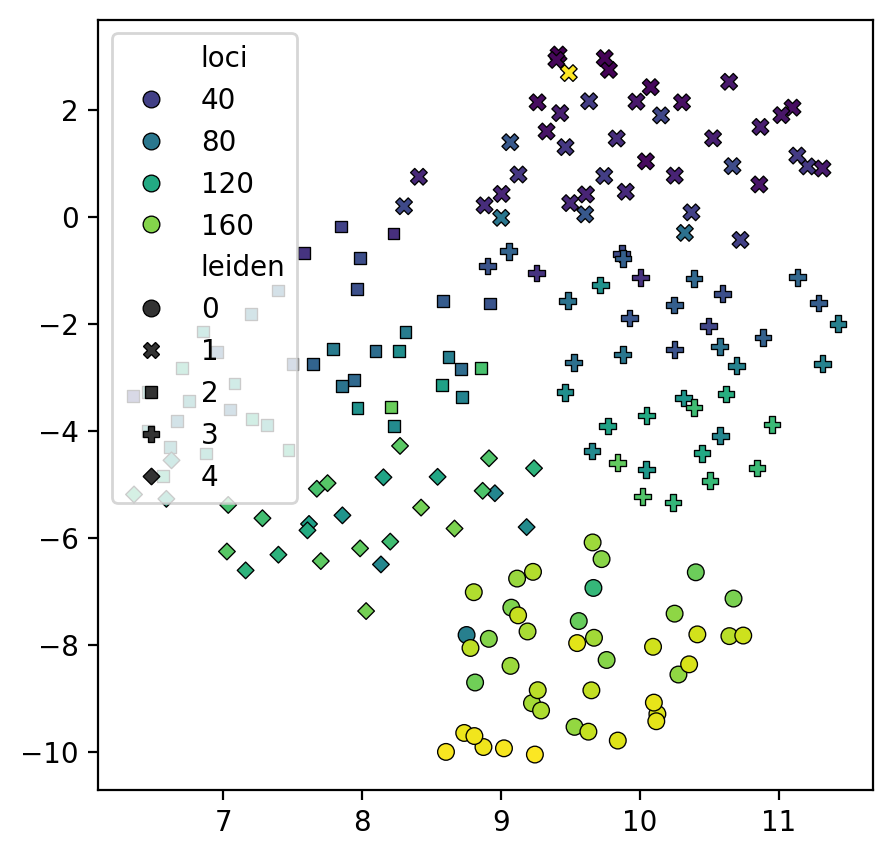

In [21]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    x=adata.obsm['X_umap'][:, 0],
    y=adata.obsm['X_umap'][:, 1],
    hue=adata.obs.index.astype(int),
    style=adata.obs['leiden'],
    ec='k',
    palette='viridis',
)


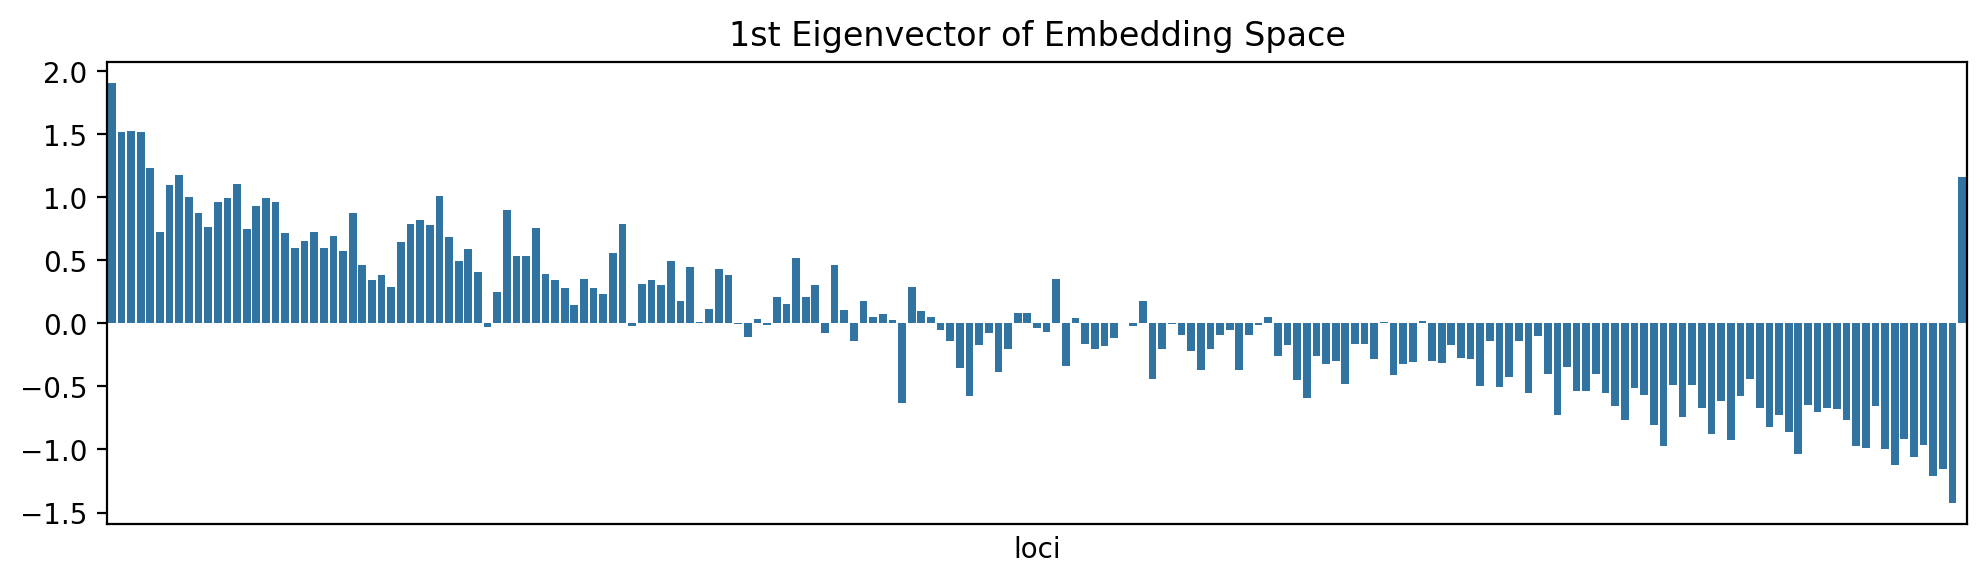

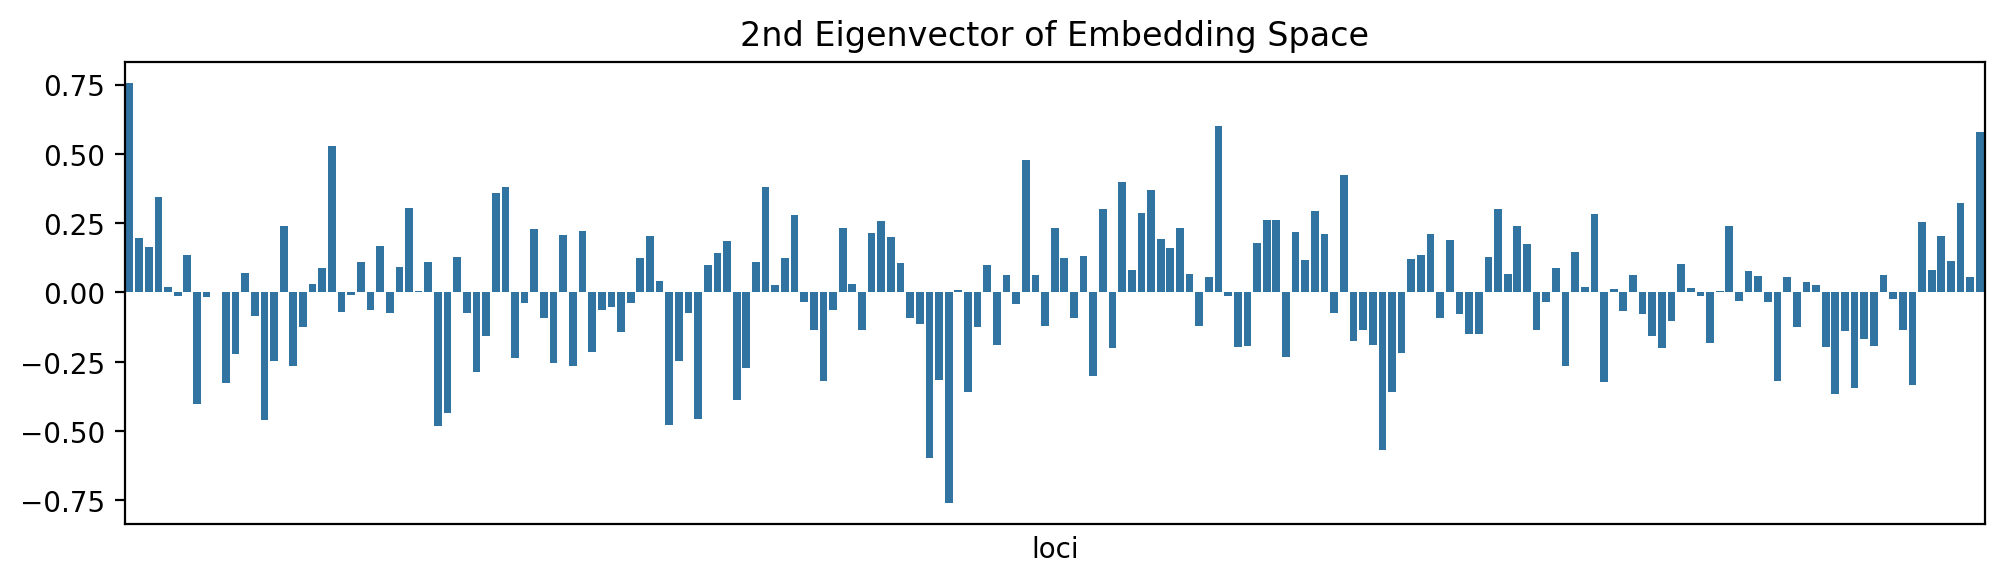

In [9]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 12, 3

sns.barplot(x=adata.obs_names.astype(int),
            y=adata.obsm['X_pca'][:, 0],
            )

plt.title("1st Eigenvector of Embedding Space")
plt.xticks([])
plt.show()

sns.barplot(x=adata.obs_names.astype(int),
            y=adata.obsm['X_pca'][:, 1],
            )
plt.title("2nd Eigenvector of Embedding Space")
plt.xticks([])
plt.show()

In [10]:
# break

# AB Compartments

/home/cstansbu/git_repositories/higher-order-single-cell/source/matrix.py:290: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = np.divide(matrix, toeplitz_matrix)


A.shape=(193, 193)


([], [])

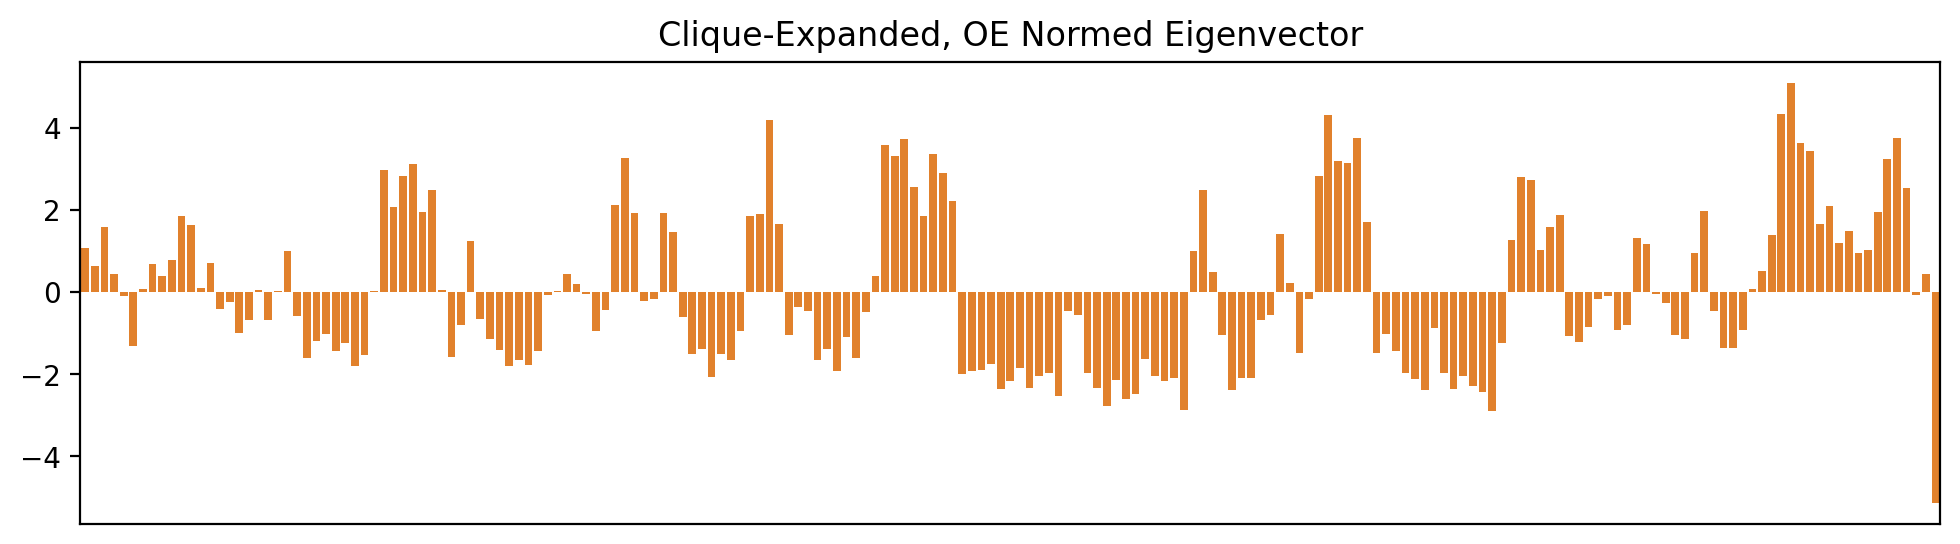

In [11]:
A = matrix.clique_expand_incidence(df, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

A = matrix.normalize_oe(matrix.normalize_kr(A).todense())
A = np.asarray(A)

print(f"{A.shape=}")

pca = PCA(n_components=2)
pca.fit(A)
X_pca = pca.transform(A)

sns.barplot(x=range(len(X_pca)),
            y=X_pca[:, 0],
            color='C1')

plt.title("Clique-Expanded, OE Normed Eigenvector")

plt.xticks([])

In [12]:
component = 1
comp_vec = adata.obsm['X_pca'][:, component]

print(f"{X_pca[:, 0].shape=}")
print(f"{comp_vec.shape=}")

scipy.stats.pearsonr(X_pca[:, 0], comp_vec)

X_pca[:, 0].shape=(193,)
comp_vec.shape=(193,)


PearsonRResult(statistic=-0.40770713265922287, pvalue=3.981330605490938e-09)

A.shape=(193, 193)


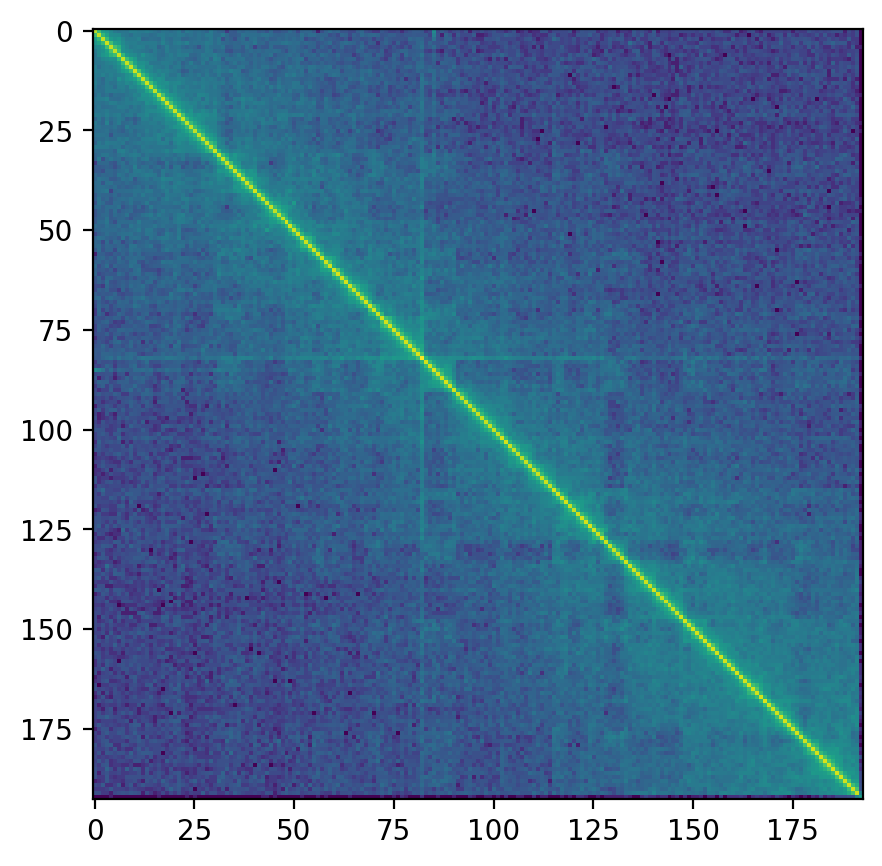

In [22]:
A = matrix.clique_expand_incidence(df, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

print(f"{A.shape=}")

plt.imshow(np.log1p(A))

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# hyperedge embeddings

In [ ]:
# geneformer-style embeddings for hyperedges
edge_embeddings = embeddings.mean(axis=1).cpu().detach().numpy()  
print(f"{edge_embeddings.shape=}")

obs_names = [f"Obs_{i}" for i in range(len(edge_embeddings))]
sample['obs_names'] = obs_names

# Create AnnData object
adata = an.AnnData(
    X=edge_embeddings,
    obs=sample.set_index('obs_names')
)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(
    adata,
    color=["order", "leiden"],
    ncols=1,
    size=15,
)

adata

In [ ]:
adata.obs.explode('input_ids')['input_ids'].value_counts()

In [ ]:
# look a each cluster:

for cluster, group in adata.obs.groupby('leiden'):
    print(f"{cluster=}")
    
    group = group.explode('input_ids')
    group = group[group['input_ids'] != 0]
    print(group['input_ids'].value_counts().head(5))
    
    

In [ ]:
A = matrix.clique_expand_incidence(df, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

print(f"{A.shape=}")

plt.imshow(np.log1p(A))
# plt.axvline(x=86, c='r', alpha=0.2, lw=2)
# plt.axhline(y=86, c='r', alpha=0.2, lw=2)

In [ ]:
# just each group

# look a each cluster:
for cluster, group in adata.obs.groupby('leiden'):
    I = ut.list_of_list_to_incidence(group['raw_input'].to_list())
    I = pd.DataFrame(I)
    I = ut.fill_missing_bins(I, df.index)
    print(f"{I.shape}")
    
    A = matrix.clique_expand_incidence(I, zero_diag=False) 
    plt.imshow(np.log1p(A))
    plt.title(f"{cluster=}")
    plt.show()